In [2]:
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


C:\Users\Lithium\AppData\Local\Temp\ipykernel_22756\1438968273.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  from pandas import read_csv, DataFrame


In [3]:
# 数据准备 
# server p1_points_won p2_points_won point_victor
from numpy import array
df = read_csv('2024c\processed_data/2023-wimbledon-1401', index_col=[0])
p1_points_won,p2_points_won = df['p1_points_won'], df['p2_points_won']
server, point_victor = df['server'], df['point_victor']

server_p1, server_p2 = [0]*len(server), [0]*len(server)
for i,j in enumerate(server.tolist()):
    if j == 1: server_p1[i] = 1
    else: server_p2[i] = 1
server_p1, server_p2 = array(server_p1), array(server_p2 )


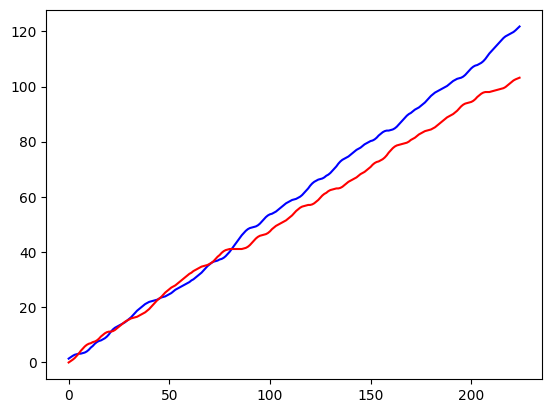

In [4]:
# 平滑p1_points_won p2_points_won数据
from scipy.signal import savgol_filter
window_size = 5  # 窗口大小
poly_order = 1  # 多项式拟合阶数
p1_points = savgol_filter(p1_points_won, window_size, poly_order)
p2_points = savgol_filter(p2_points_won, window_size, poly_order)
# plt.subplot(title='before')
# plt.plot(p1_points_won, color='blue')
# plt.plot(p2_points_won, color='red')
# plt.subplot(title='after')
plt.plot(p1_points, color='blue')
plt.plot(p2_points, color='red')

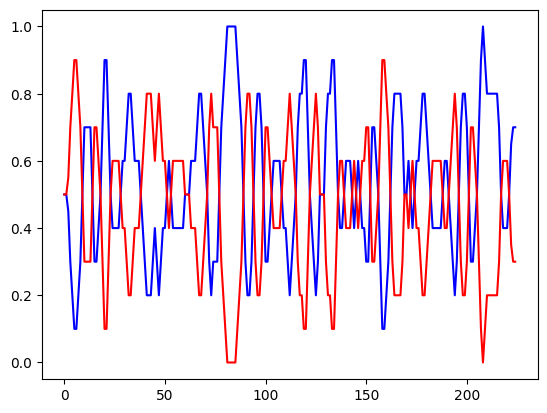

In [5]:
# 算速度
from numpy import gradient, interp, linspace, sum
def grad_n_times(df, n=1):
    for _ in range(n):
        df = gradient(df)
    return df

derive1 = grad_n_times(p1_points) # 无插值算速度
derive2 = grad_n_times(p2_points)
plt.plot(derive1, color='blue')
plt.plot(derive2, color='red')

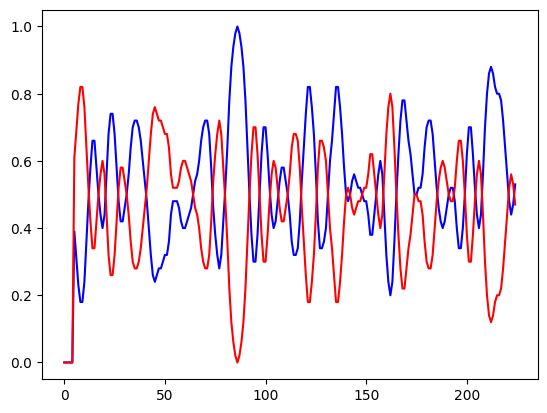

In [6]:
# 滑动窗口
from numpy import array
def win_avg(df, window_size=5):
    return array([sum(df[idx-window_size:idx])/window_size for idx in range(len(df))])

derive1_winavg = win_avg(derive1)
derive2_winavg = win_avg(derive2)
plt.plot(derive1_winavg, color='blue')
plt.plot(derive2_winavg, color='red')


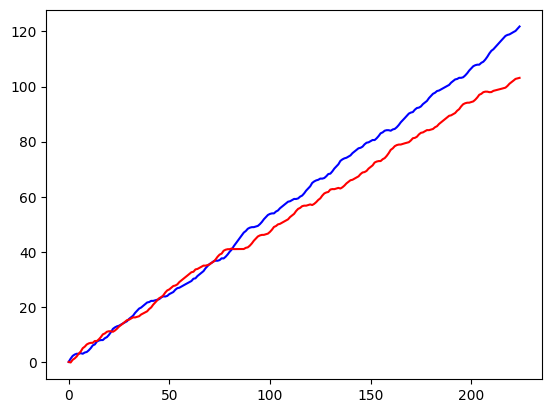

In [7]:
# ARIMA预测
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
def arima_predict(p_points,end=-1):
    model = ARIMA(endog=p_points, order=(2,1,2))
    model_fit = model.fit()
    end = len(p_points)-1 if end==-1 else end
    predictions = list(model_fit.predict(start=0,end=end))
    # start = 10
    # window_size = 5
    # plt.plot(p1_points[start+240:], color='green')
    # plot_predict(model_fit, start=start+240, end=len(p_points), dynamic=False)
    # plt.show()
    return array(predictions)

predict_p1_score = arima_predict(p1_points)
predict_p2_score = arima_predict(p2_points)
plt.plot(predict_p1_score, color='blue')
plt.plot(predict_p2_score, color='red')

In [8]:
# 均值
print(derive1_winavg.mean(), grad_n_times(predict_p1_score, 1).mean())

0.525911111111111 0.5457915900281664


In [9]:
# 动量因素: 预测速度, 平均速度, 发球方, 胜出盘数差值
dif_p1_p2_points = p1_points - p2_points
dif_p2_p1_points = p2_points - p1_points 
def momentum(predict_p_score, derive_winavg, server, dif):
    print("各组分贡献: ",end='')
    print(server.mean()*5,dif.mean()*0.5,grad_n_times(predict_p_score,1).mean()*10, derive_winavg.mean()*10)
    return server*5 + dif*0.5 + grad_n_times(predict_p_score,1)*10 + derive_winavg*10 

各组分贡献: 2.3555555555555556 2.851999999999999 5.457915900281663 5.25911111111111
各组分贡献: 2.6444444444444444 -2.851999999999999 4.584562386757415 4.518666666666666


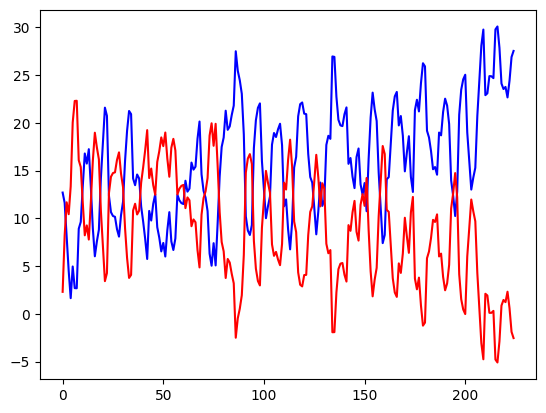

In [12]:
p1_momentum = momentum(predict_p1_score, derive1_winavg, server_p1, dif_p1_p2_points)
p2_momentum = momentum(predict_p2_score, derive2_winavg, server_p2, dif_p2_p1_points)
plt.plot(p1_momentum, color='blue')
plt.plot(p2_momentum, color='red')

In [ ]:
p1_momentum.to_csv("p1moentum.csv")
p2_momentum.to_csv("p2moentum.csv")

In [11]:
# 积分
from numpy import sum
def pre_sum(p_momentum):
    return array([sum(p_momentum[:i]) for i in range(len(p_momentum))])
presum_p1 = pre_sum(p1_momentum)
presum_p2 = pre_sum(p2_momentum)
# plt.plot(presum_p1, color='blue')
# plt.plot(presum_p2, color='red')